# [ 프로젝트 : 주식 예측에 도전해 보자 ]


### STEP 1 : 시계열 데이터 준비

   * 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
   * 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
data_file = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(data_file,index_col="Date",parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


### STEP 2 : 각종 전처리 수행

   * 결측치 처리
   * 로그 변환


In [3]:
ts = df['Close']
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [4]:
if not ts[ts.isna()].empty:
    ts=ts.interpolate(method='time')
    ts[ts.isna()]

/home/myungjin-kim/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


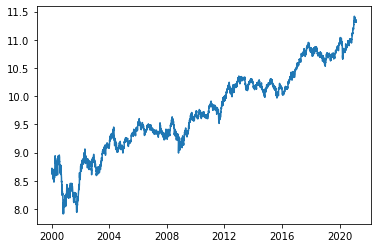

In [5]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인 

In [6]:
def plot_rolling_statistics(timeseries, window):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

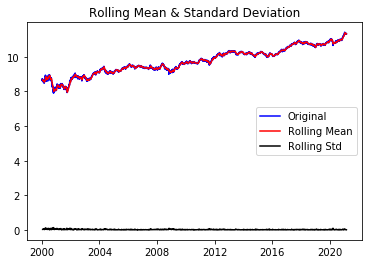

In [8]:
# plt.plot(ts_log)
plot_rolling_statistics(ts_log,window=12)

In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.325391
p-value                           0.921830
#Lags Used                        4.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


In [10]:
len(ts_log)

5318

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicity', freq = 365)
#decomposition = seasonal_decompose(ts_log, model='additive', freq = 30)
# https://dodonam.tistory.com/89

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

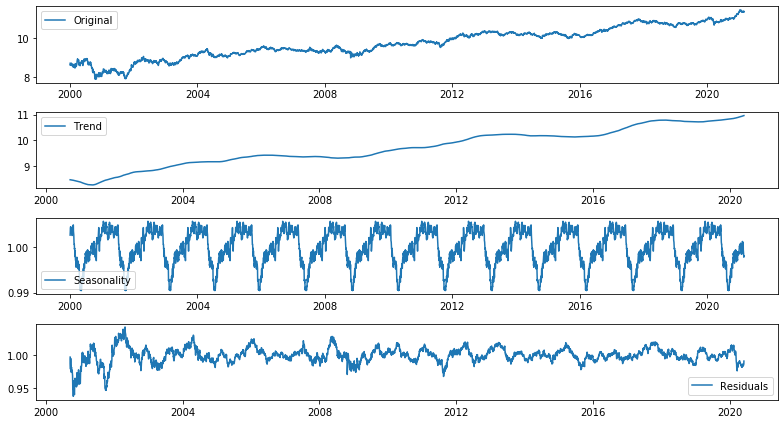

In [12]:
plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.777240e+00
p-value                        8.604107e-12
#Lags Used                     3.100000e+01
Number of Observations Used    4.922000e+03
Critical Value (1%)           -3.431679e+00
Critical Value (5%)           -2.862127e+00
Critical Value (10%)          -2.567083e+00
dtype: float64


### STEP 4 : 적정 ARIMA 모수 찾기

   * ACF, PACF 그려보기 -> p,q 구하기
   * 차분 안정성 확인 -> d 구하기


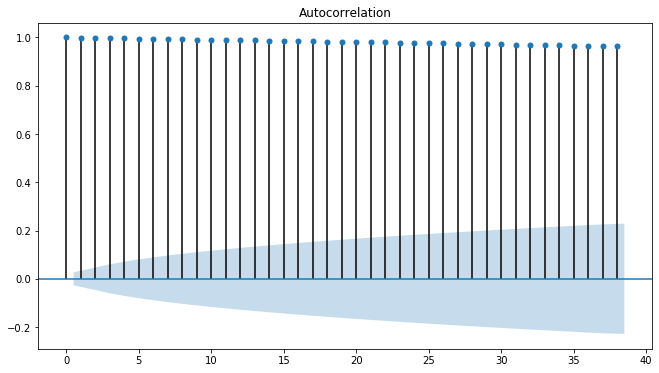

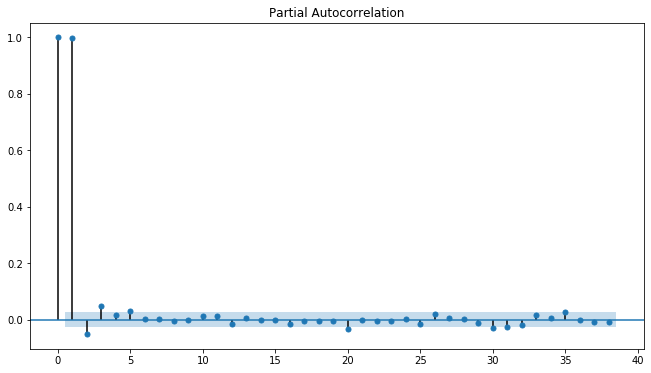

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.102097
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


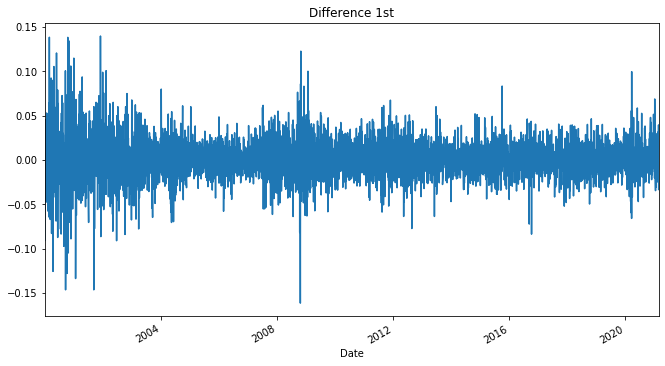

In [15]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### STEP 5 : 학습, 테스트 데이터셋 생성

   * 학습, 테스트 데이터셋 분리


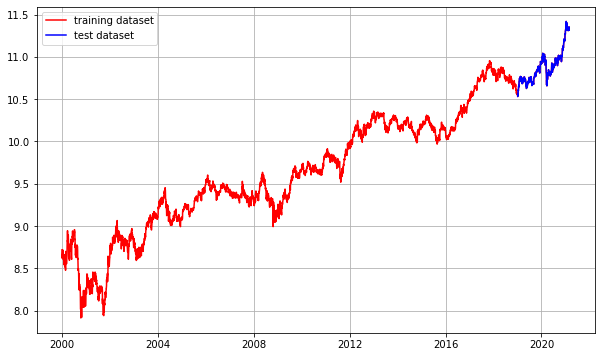

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 6 : ARIMA 모델 훈련과 테스트

   * ARIMA 모델 빌드와 훈련
   * 모델 테스트 및 플로팅
   * 최종 예측 모델 정확도 측정(MAPE)


In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4785
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11277.411
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 02 Mar 2021   AIC                         -22548.823
Time:                        21:52:55   BIC                         -22529.403
Sample:                             1   HQIC                        -22542.001
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.111      0.267      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/myungjin-kim/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/myungjin-kim/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


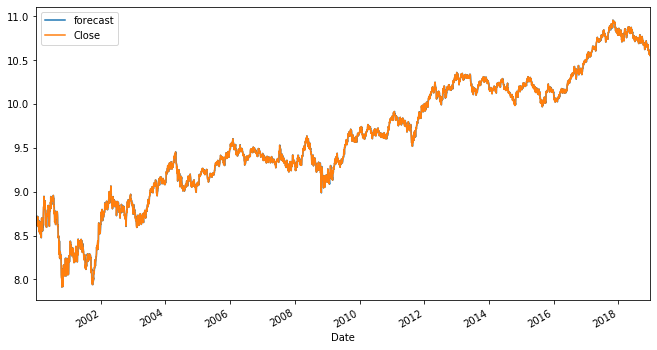

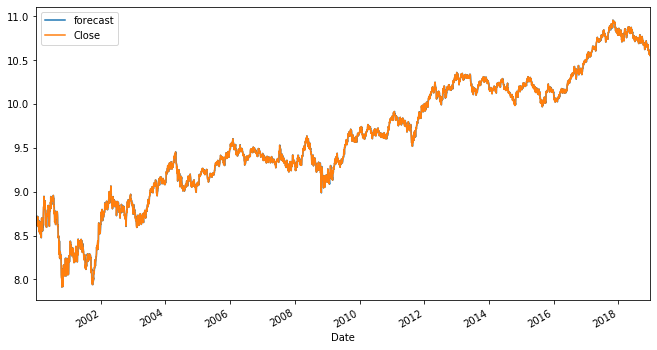

In [18]:
fitted_m.plot_predict()

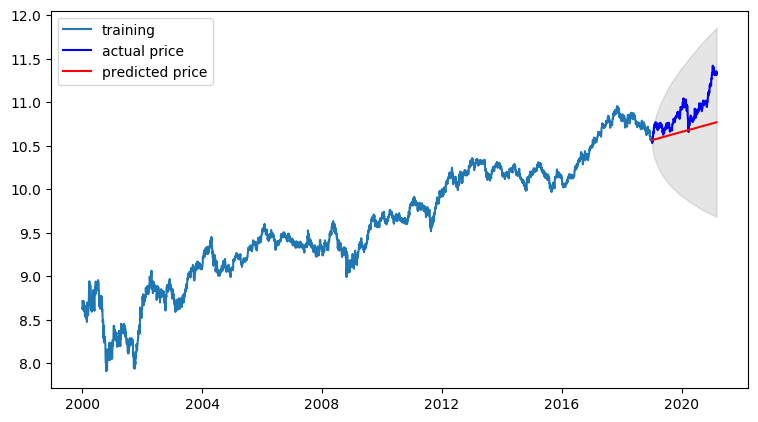

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.1)
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  214746756.1984845
MAE:  11296.36263071894
RMSE:  14654.240212255445
MAPE: 18.68%


## [ 회 고 ]

* 이번 프로젝트에서 어려웠던 점: arima의 개념과 시계열 분석의 상세 내용들 이해과정이 어려움.

* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.

    - 알아낸 점: 시계열 분석의 전반적 흐름.     
    - 모호한 점: 마지막 예측이 자꾸 단순직선으로 예측됨. model='addictive'로 하기도 하고 'multiplicity'도 해보고, freq = 12로 했다가 365로도 해보는 등 조정을 해보았는데 자꾸 p-value가 너무 작게 나왔는데 뭘 더 조정해야 할지 모르겠음.